## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Stakeholders:
Homeowners in the King County area

Our Recommendations will provide: 
Homeowners with guidance on home renovation projects (e.g. converting half bath to full bath or adding garage/patio) that could potentially enhance the value of their homes and estimate the average increase in sales price.

In [3]:
# Import tools and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from statsmodels.tools.eval_measures import rmse

sns.set(font_scale = 1)

In [4]:
# Import main dataset as dataframe

df = pd.read_csv('data/kc_house_data.csv')

# BEGIN DATA CLEANING

In [5]:
# Check initial datasframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [6]:
# Clean data by dropping columns deemed unncessary
# We are only keeping our target variable (price) and variables that the homeowner can easily control/change

df_model = df[['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_garage', 'sqft_patio']]

In [7]:
df_model

price  bedrooms  bathrooms      grade  sqft_garage  sqft_patio
0       675000.0         4        1.0  7 Average            0          40
1       920000.0         5        2.5  7 Average            0         240
2       311000.0         6        2.0  7 Average            0           0
3       775000.0         3        3.0   9 Better          200         270
4       592500.0         2        2.0  7 Average          550          30
...          ...       ...        ...        ...          ...         ...
30150  1555000.0         5        2.0     8 Good            0         210
30151  1313000.0         3        2.0  7 Average            0         520
30152   800000.0         3        2.0  7 Average          240         110
30153   775000.0         3        2.5     8 Good          480         100
30154   500000.0         3        1.5  7 Average          420           0

[30155 rows x 6 columns]

In [8]:
# Extract numeric values from 'Grade' column and convert to integers

df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)

<ipython-input-8-c457f4d0c4d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)


In [9]:
# Removing outliers by setting lower and upper bounds

iqr = (df_model['price'].quantile(0.75) - df_model['price'].quantile(0.25))

upper = df_model['price'].quantile(0.75) + (1.5 * iqr)
lower = df_model['price'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(652000.0, 2278000.0, -330000.0)

In [10]:
# Removing prices outside the lower and upper bounds

df_model_iqr = df_model[(df_model['price'] > lower) & (df_model['price'] < upper)]

In [11]:
df_model_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28161 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        28161 non-null  float64
 1   bedrooms     28161 non-null  int64  
 2   bathrooms    28161 non-null  float64
 3   grade        28161 non-null  object 
 4   sqft_garage  28161 non-null  int64  
 5   sqft_patio   28161 non-null  int64  
 6   grade_num    28161 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.7+ MB


# END DATA CLEANING

## BUILDING DUMMY REGRESSOR MODEL

In [12]:
# Defining X and y to be used in dummy model

X = df_model_iqr.drop(columns=['price', 'grade'])
y = df_model_iqr['price']

In [13]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate linear regression model and fit to training data
lm = LinearRegression().fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [14]:
# Print results from dummy model

print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))
  
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

Mean squared error (dummy): 186389718514.87
Median absolute error (dummy): 245000.00
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.06


In [15]:
# Using stats-model to check sklearn dummy model results
df_dummy = df_model_iqr.copy()

df_dummy['avg_price'] = df_dummy['price'].mean()
X = df_dummy['avg_price']
y = df_dummy['price']
dummy_model = sm.OLS(y, sm.add_constant(X)).fit()

dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 15 Feb 2023   Prob (F-statistic):                nan
Time:                        10:53:05   Log-Likelihood:            -4.0557e+05
No. Observations:               28161   AIC:                         8.111e+05
Df Residuals:                   28160   BIC:                         8.111e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avg_price      1.0000      0.003    363.325      0.000       0.995       1.005
==============================================================================
Omnibus:                     2949.546   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3959.177
Skew:                           0.904   Prob(JB):                         0.00
Kurtosis:                       3.329   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Calculate and return root-mean-square-error (RMSE)

ypred = dummy_model.predict(X)

rmse = rmse(y, ypred)
rmse

434878.46504904696

## BUILDING FIRST SIMPLE MODEL

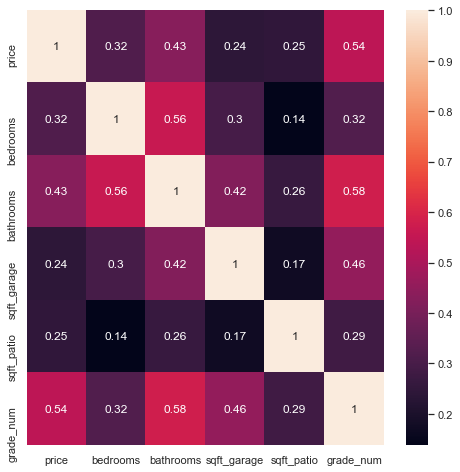

In [17]:
# Correlation heatmap to identify variable most correlated with price

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(df_model_iqr.corr(), annot=True);

We can see that 'grade_num' has the highest correlation to 'price', followed by 'bathrooms'.

In [18]:
# Creating simple model with the most correlated variable

X = df_model_iqr['grade_num']
y = df_model_iqr['price']

first_model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 1.159e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:53:05   Log-Likelihood:            -4.0072e+05
No. Observations:               28161   AIC:                         8.014e+05
Df Residuals:                   28159   BIC:                         8.015e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.158e+05   1.65e+04    -49.526      0.000   -8.48e+05   -7.83e+05
grade_num   2.338e+05   2172.340    107.637      0.000     2.3e+05    2.38e+05
==============================================================================
Omnibus:                     2132.975   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2739.818
Skew:                           0.687   Prob(JB):                         0.00
Kurtosis:                       3.670   Cond. No.                         58.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Checking Residual Values

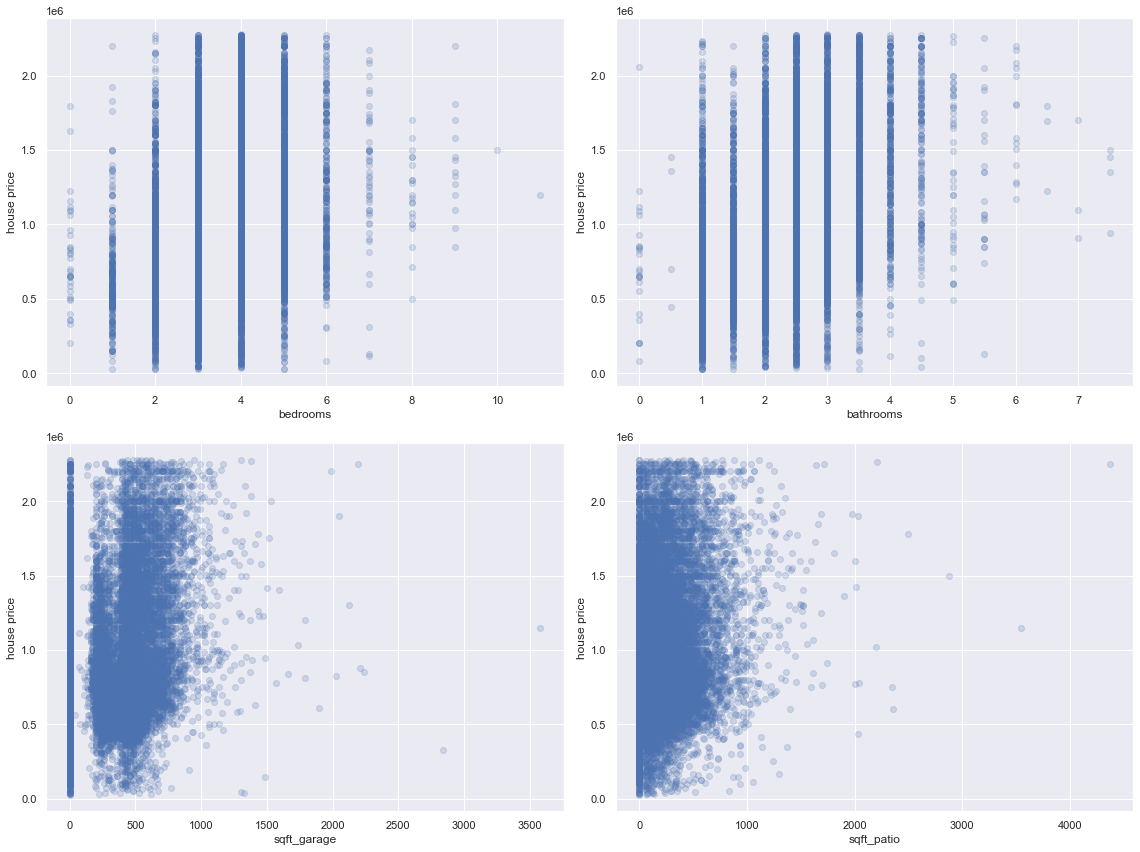

In [19]:
# Create scatter plots of remaining variables 

scatterplot_data = X_train.drop('grade_num', axis=1)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//2][index%2]
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("house price")

## BUILDING MODEL WITH ALL FEATURES

In [20]:
# Create training model with all variables

sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     2129.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:53:06   Log-Likelihood:            -2.9990e+05
No. Observations:               21120   AIC:                         5.998e+05
Df Residuals:                   21114   BIC:                         5.999e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.296e+05   2.09e+04    -39.746      0.000   -8.71e+05   -7.89e+05
bedrooms     5.451e+04   3098.843     17.589      0.000    4.84e+04    6.06e+04
bathrooms    6.443e+04   4378.355     14.716      0.000    5.58e+04     7.3e+04
sqft_garage   -93.8720     10.354     -9.066      0.000    -114.167     -73.577
sqft_patio    154.8538     11.274     13.735      0.000     132.756     176.952
grade_num     1.92e+05   3157.516     60.812      0.000    1.86e+05    1.98e+05
==============================================================================
Omnibus:                     1511.160   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1951.954
Skew:                           0.652   Prob(JB):                         0.00
Kurtosis:                       3.719   Cond. No.                     4.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## IDENTIFYING HOMEOWNER RENOVATION IMPACT ON PRICE

In [21]:
#Splitting data into combinations of garage and patio presence

no_garage_no_patio = df_model_iqr[(df_model_iqr['sqft_garage'] == 0) & (df_model_iqr['sqft_patio'] == 0)]
garage_no_patio = df_model_iqr[(df_model_iqr['sqft_garage'] > 0) & (df_model_iqr['sqft_patio'] == 0)]
no_garage_patio = df_model_iqr[(df_model_iqr['sqft_garage'] == 0) & (df_model_iqr['sqft_patio'] > 0)]
garage_patio = df_model_iqr[(df_model_iqr['sqft_garage'] > 0) & (df_model_iqr['sqft_patio'] > 0)]


In [22]:
# Defining x and y to visualize garage and patio impact on price

x = ['Neither', 'Garage Only', 'Patio Only', 'Both']

y = np.array([no_garage_no_patio['price'].mean(), garage_no_patio['price'].mean(),
     no_garage_patio['price'].mean(), garage_patio['price'].mean()], dtype='f')

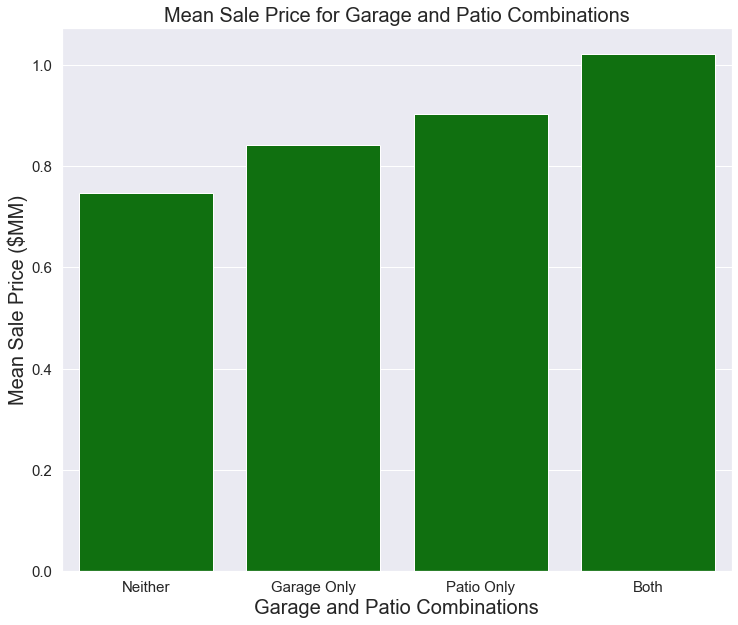

In [23]:
# Plotting garage and patio presence impact on mean price

fig, ax = plt.subplots(figsize = (12, 10))

y = y / 1000000

fig = sns.barplot(x = x,
                  y = y,
                  color='green')

plt.xlabel('Garage and Patio Combinations', size=20)
plt.xticks(fontsize=15)
plt.ylabel('Mean Sale Price ($MM)', size=20)
plt.yticks(fontsize=15)
plt.title('Mean Sale Price for Garage and Patio Combinations', size=20)
plt.show(fig);

In [24]:
df_model_iqr.head()

price  bedrooms  bathrooms      grade  sqft_garage  sqft_patio  \
0  675000.0         4        1.0  7 Average            0          40   
1  920000.0         5        2.5  7 Average            0         240   
2  311000.0         6        2.0  7 Average            0           0   
3  775000.0         3        3.0   9 Better          200         270   
4  592500.0         2        2.0  7 Average          550          30   

   grade_num  
0          7  
1          7  
2          7  
3          9  
4          7

## CALCULATE PRICE DIFFERENCE WITH BATHROOM RENOVATIONS

In [25]:
bath_dummies = pd.get_dummies(df_model_iqr['bathrooms'], prefix='bath')
df_model_iqr_bath = pd.concat([df_model_iqr, bath_dummies], axis=1)
df_model_iqr_bath

price  bedrooms  bathrooms      grade  sqft_garage  sqft_patio  \
0       675000.0         4        1.0  7 Average            0          40   
1       920000.0         5        2.5  7 Average            0         240   
2       311000.0         6        2.0  7 Average            0           0   
3       775000.0         3        3.0   9 Better          200         270   
4       592500.0         2        2.0  7 Average          550          30   
...          ...       ...        ...        ...          ...         ...   
30150  1555000.0         5        2.0     8 Good            0         210   
30151  1313000.0         3        2.0  7 Average            0         520   
30152   800000.0         3        2.0  7 Average          240         110   
30153   775000.0         3        2.5     8 Good          480         100   
30154   500000.0         3        1.5  7 Average          420           0   

       grade_num  bath_0.0  bath_0.5  bath_1.0  ...  bath_3.0  bath_3.5  \
0              7         0         0         1  ...         0         0   
1              7         0         0         0  ...         0         0   
2              7         0         0         0  ...         0         0   
3              9         0         0         0  ...         1         0   
4              7         0         0         0  ...         0         0   
...          ...       ...       ...       ...  ...       ...       ...   
30150          8         0         0         0  ...         0         0   
30151          7         0         0         0  ...         0         0   
30152          7         0         0         0  ...         0         0   
30153          8         0         0         0  ...         0         0   
30154          7         0         0         0  ...         0         0   

       bath_4.0  bath_4.5  bath_5.0  bath_5.5  bath_6.0  bath_6.5  bath_7.0  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
30150         0         0         0         0         0         0         0   
30151         0         0         0         0         0         0         0   
30152         0         0         0         0         0         0         0   
30153         0         0         0         0         0         0         0   
30154         0         0         0         0         0         0         0   

       bath_7.5  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
30150         0  
30151         0  
30152         0  
30153         0  
30154         0  

[28161 rows x 23 columns]

In [26]:
# Only the price and new bathroom columns
df_regr = df_model_iqr_bath[['price', 'bath_1.0', 'bath_1.5', 'bath_2.0', 'bath_2.5', 'bath_3.0', 'bath_3.5', 'bath_4.0', 'bath_4.5', 'bath_5.0', 'bath_5.5']]
df_regr = sm.add_constant(df_regr)

# Fit the linear regression model
model = sm.OLS(df_regr['price'], df_regr.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     673.7
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:53:06   Log-Likelihood:            -4.0255e+05
No. Observations:               28161   AIC:                         8.051e+05
Df Residuals:                   28150   BIC:                         8.052e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.164e+06   4.77e+04     24.389      0.0

Each one-unit increase in homes with 1 bathrooms is associated with a decrease in price of approximately $491,000.

The coefficient for for homes with 2 and half bathrooms is a one-unit increase in bath_2.5 is associated with a decrease in price of approximately $164,000.

On the other hand, for homes with 3 and a half bathrooms is associated with an increase in price of approximately $145,000.

To renovate a home with 1 bathroom to a 1 and half bath increases price by $80,000. 

To renovate a home with 1 and half bath to 2 bath increases price by $99,000.

To renovate a home with 2 bath to a 2 and half bath increases price by $148,100. 


## CALCULATE PRICE DIFFERENCE WITH BEDROOM RENOVATIONS

In [31]:
bed_dummies = pd.get_dummies(df_model_iqr['bedrooms'], prefix='bed')
df_model_iqr_bed = pd.concat([df_model_iqr, bed_dummies], axis=1)
df_model_iqr_bed

price  bedrooms  bathrooms      grade  sqft_garage  sqft_patio  \
0       675000.0         4        1.0  7 Average            0          40   
1       920000.0         5        2.5  7 Average            0         240   
2       311000.0         6        2.0  7 Average            0           0   
3       775000.0         3        3.0   9 Better          200         270   
4       592500.0         2        2.0  7 Average          550          30   
...          ...       ...        ...        ...          ...         ...   
30150  1555000.0         5        2.0     8 Good            0         210   
30151  1313000.0         3        2.0  7 Average            0         520   
30152   800000.0         3        2.0  7 Average          240         110   
30153   775000.0         3        2.5     8 Good          480         100   
30154   500000.0         3        1.5  7 Average          420           0   

       grade_num  bed_0  bed_1  bed_2  bed_3  bed_4  bed_5  bed_6  bed_7  \
0              7      0      0      0      0      1      0      0      0   
1              7      0      0      0      0      0      1      0      0   
2              7      0      0      0      0      0      0      1      0   
3              9      0      0      0      1      0      0      0      0   
4              7      0      0      1      0      0      0      0      0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
30150          8      0      0      0      0      0      1      0      0   
30151          7      0      0      0      1      0      0      0      0   
30152          7      0      0      0      1      0      0      0      0   
30153          8      0      0      0      1      0      0      0      0   
30154          7      0      0      0      1      0      0      0      0   

       bed_8  bed_9  bed_10  bed_11  
0          0      0       0       0  
1          0      0       0       0  
2          0      0       0       0  
3          0      0       0       0  
4          0      0       0       0  
...      ...    ...     ...     ...  
30150      0      0       0       0  
30151      0      0       0       0  
30152      0      0       0       0  
30153      0      0       0       0  
30154      0      0       0       0  

[28161 rows x 19 columns]

In [40]:
bed_correlations = df_model_iqr_bed[['price', 'bedrooms', 'bed_0', 'bed_1', 'bed_2', 'bed_3', 'bed_4', 'bed_5', 'bed_6', 'bed_7', 'bed_8', 'bed_9', 'bed_10', 'bed_11']]

bed_correlations = sm.add_constant(bed_correlations)

# Fit the linear regression model
model = sm.OLS(bed_correlations['price'], bed_correlations.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     262.4
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:19:15   Log-Likelihood:            -4.0396e+05
No. Observations:               28161   AIC:                         8.079e+05
Df Residuals:                   28147   BIC:                         8.081e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.368e+16   2.16e+16     -1.099      0.2